In [18]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix, diags
import matplotlib.pyplot as plt
from os import listdir

import sys
sys.path += ['utils/']  

from word_embedding import * 

import warnings
warnings.filterwarnings("ignore")

In [19]:
directory = 'Bkp_vars/'

df = pd.read_csv(directory + 'events.csv')

all_visitor_id = df.visitorid.unique()
n = len(all_visitor_id)
visitor_mapper = dict(zip(all_visitor_id, np.arange(n)))

all_item_id = df.itemid.unique()
m = len(all_item_id)
item_mapper = dict(zip(all_item_id, np.arange(m)))

df.visitorid = df.visitorid.map(lambda x: visitor_mapper[x])
df.itemid = df.itemid.map(lambda x: item_mapper[x])

event_mapper = dict(zip(df.event.unique(), np.array([1,2,3])))
df.event = df.event.map(lambda x: event_mapper[x])

nrows = len(df)

In [20]:
def RunSimulation(dim):

    pv = [0.1, 0.3, 0.5, 0.7, 0.9]

    Fscore = []


    for p in pv[::-1]:
        print(p, end = '\r')
        
        # create train and test sets
        train_bool = np.random.binomial(1, p, nrows) == 1
        df_train = df[train_bool]
        df_test = df[~train_bool]

        # obtain the probability matrix from the train set
        A = csr_matrix((df_train.event, (df_train.visitorid, df_train.itemid)), shape = (n,m))
        D_1 = diags((A@np.ones(m))**(-1))
        P = D_1@A
        
        # compute the embeddings
        res = CreateEmbedding([P], dim = dim, n_epochs = 30, η = 0.8, sym = False)

        # true positives
        tp = np.mean((res.X[df.visitorid] * res.Y[df.itemid]).sum(axis = 1) > 0)
        
        # false negatives
        fn = 1 - tp
        
        # true negatives
        idxa, idxb = np.random.choice(np.arange(n), len(df)), np.random.choice(np.arange(m), len(df))
        tn = np.mean((res.X[idxa] * res.Y[idxb]).sum(axis = 1) < 0)
        
        # false positives
        fp = 1 - tn

        
        precision = tp/(tp + fp)
        recall = tp/(tp + fn)

        Fscore.append(2/(1/precision + 1/recall))
        
    # save the result
    Fscore = pd.DataFrame(Fscore)
    try:
        nn = (np.max([int(x.split('_')[1]) for x in listdir('saved_files/matrix_completion')]))
        print(nn)
        Fscore.to_csv('saved_files/matrix_completion/v_' + str(nn+1) + '_.csv', index = False)

    except:
        Fscore.to_csv('saved_files/matrix_completion/v_' + str(1) + '_.csv', index = False)

In [21]:
# dim = 32
# n_sim = 4
# for i in range(n_sim):
#     RunSimulation(dim)

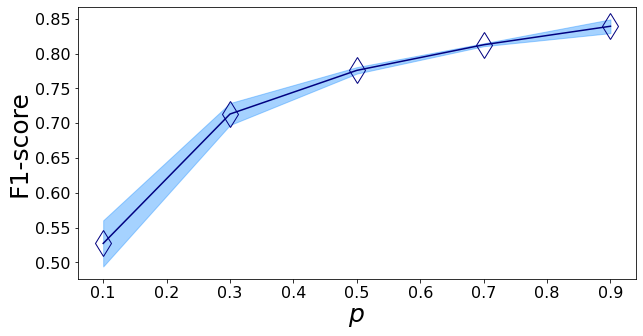

In [23]:
directory = 'saved_files/matrix_completion/'
files = listdir(directory)

data = []

for f in files:
    data.append(pd.read_csv(directory + f))
    
data = pd.concat(data, axis = 1)

pv = [0.1, 0.3, 0.5, 0.7, 0.9]

μ = data.mean(axis = 1)
σ = data.std(axis = 1) 

plt.figure(figsize = (10,5))

plt.plot(pv[::-1], μ, color = 'navy', marker = 'd', markersize = 18, fillstyle = 'none')
plt.fill_between(pv[::-1], μ - σ, μ + σ, color = 'dodgerblue', alpha = 0.4)
plt.xlabel(r'$p$', fontsize = 25)
plt.ylabel('F1-score', fontsize = 25)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
# plt.savefig('../../paper/v2/arXiv/Figures/mat_comp.pdf', dpi = 400, bbox_inches = 'tight')
plt.show();